In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from collections import Counter
import math

plt.style.use('ggplot')

In [2]:
# This function implements the KNN classifier
# This function computes the euclidean distance between data points
def euclidean_distance(x_s,y_s):
    # Iterates each element from both arrays, take its difference and power 2 before square root
    return np.sqrt(np.sum((x_s-y_s)**2))

# This function implements the Knn classifier
def knn(k, predicted_dp, pool):
    distances = [euclidean_distance(np.array([predicted_dp[0], predicted_dp[1]]),np.array([x, y])) for x, y, class_id in pool]
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]


# Read dataset

In [3]:
df = pd.read_csv('hw5data.txt', sep= ' ', names= ['x','y', 'class'])
df

,x,y,class
0,0.776233,0.052780,1
1,0.992234,0.087356,1
2,0.263741,0.131315,1
3,0.079478,0.109225,1
4,0.688997,0.983182,1
...,...,...,...
802,0.932700,0.875138,0
803,0.541090,0.555108,0
804,0.988755,0.194709,0
805,0.263414,0.974600,0


<Axes: ylabel='Frequency'>

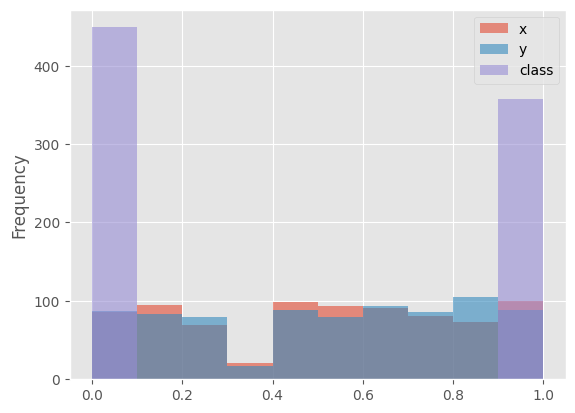

In [4]:
df.plot(kind= 'hist', alpha=0.6)

<Axes: xlabel='x', ylabel='y'>

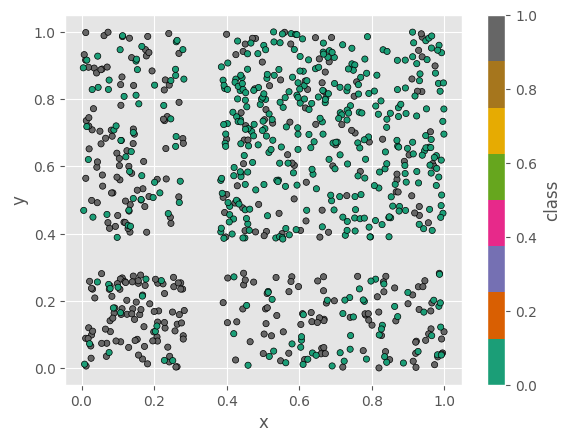

In [5]:
df.plot(x= 'x', y = 'y', c='class', kind= 'scatter', colormap= 'Dark2', edgecolor='k')

In [6]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[0:1:30j,0:1:30j]

n = 20
k = 1

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 
P = df.to_numpy() 
print(f'Dataset of target classifier: {P.shape}')

# Teaching/ student classifier, f: It has a array D which picks elements from P (hw5data.txt) D is a 
# subset or proper set of P, which holds the data points we want to include in teaching.
D = np.array([])
print(f'Dataset of teaching classifier: {D.shape}')

Dataset of target classifier: (807, 3)
Dataset of teaching classifier: (0,)


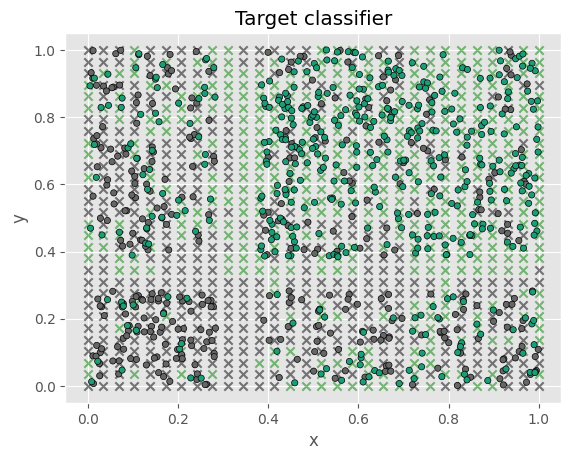

In [7]:
colors = {0: 'green', 1:'black'}
# View decision boundary of target classifier using all data points from the orignal pool
for X, Y in zip(mesh_X, mesh_Y):
    for x, y in zip(X, Y):
        result = knn(k, [x,y], P)
        plt.scatter(x,y, c= colors[result],alpha= 0.5, marker='x')
        
temp_P = P.T
plt.scatter(temp_P[0], temp_P[1], c=temp_P[2], edgecolor='k', cmap='Dark2', s=20)
plt.title('Target classifier')
plt.xlabel('x')
plt.ylabel('y')
        
plt.show()

In [8]:
# We than use the dense grid to map it onto both the target classifier and teaching classifier. This generates
# feature vectors (x_{1}, x_{2}, y) with the same dimensions.

# Both feature vectors are fed into the disagreement function, which compares each dense grid points correspondingly
# by comparing their corresponding
# f(x') - computed from teaching classifier, and y' - computed from target classifiers which is defined in the disagreement function.
# Return the result of the unified cost function.

# Use that cost function result to do enumeration and greedy respectively. 

# Map the dense 2D grid to the target classifier, since we will be using it for all comparisons.


In [ ]:
# Enumeration

# This function
def find_combination(n, pool):
    datasets = combinations(pool, n)
    return np.array(list(datasets))

def disagreement_func(mesh_X, mesh_Y, pool_D, pool_Z):
    disagree_val = 0
    for X, Y in zip(mesh_X, mesh_Y):
        for x, y in zip(X, Y):
            disagree_val += 0 if knn(k, [x,y], pool_D) == knn(k, [x,y], pool_Z) else 1
            
    return disagree_val/mesh_X.size
    
        
# This function
def enumeration(n, pool):
    
    pool_Z = pool
    best_pool_D = None
    
    # Create a dataset enumeration function that takes in argument: n - size of teaching set
    # Call the itertools.combination function, and find all combinations of list of n data points, which will form the teaching set.
    possible_pool_Ds = find_combination(n, pool)
    
    number_of_teaching_set = len(possible_pool_Ds) 
    
    # For each combination of teaching set, run KNN, and map the dense 2D grid; take both 2D grids into the disagreement function.
    min_cost = math.inf
    for pool_D in possible_pool_Ds:
        cost = disagreement_func(mesh_X, mesh_Y, pool_D, pool_Z)
        if min_cost > cost:
            best_pool_D = pool_D
            min_cost = cost
    # Only keep the list of n data points with the least "cost" in the disagreement function.
    

enumeration(2, P)

In [ ]:
# Greedy
# Randomly pick a data point to make the teaching set's size = 1.
# Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
# Repeat until the teaching set, D reaches size n